In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os
import json
import networkx as nx
from sklearn import preprocessing
from matplotlib.cm import ScalarMappable
from matplotlib.pyplot import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
sns.set()

# Read Data

In [2]:
path = "C:/Users/18565/Desktop/Classes/VA/Project/Code/VA-Project/"

In [3]:
df = pd.read_csv(os.path.join(path,"data\Lekagul Sensor Data.csv"))
new_df = df
new_df['gate_category'] = [i[:-1] for i in list(new_df['gate-name'])]
new_df.to_csv(os.path.join(path,"data\data with added gate category for tableau.csv"))
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index("Timestamp",inplace=True)

# Create dummies

In [4]:
dummy = pd.get_dummies(df['gate-name'],dtype=int)
numerical_data = pd.concat((df,dummy),axis=1)
summary = numerical_data.describe()

# Plot Std Mean of total traffic flux at each gate

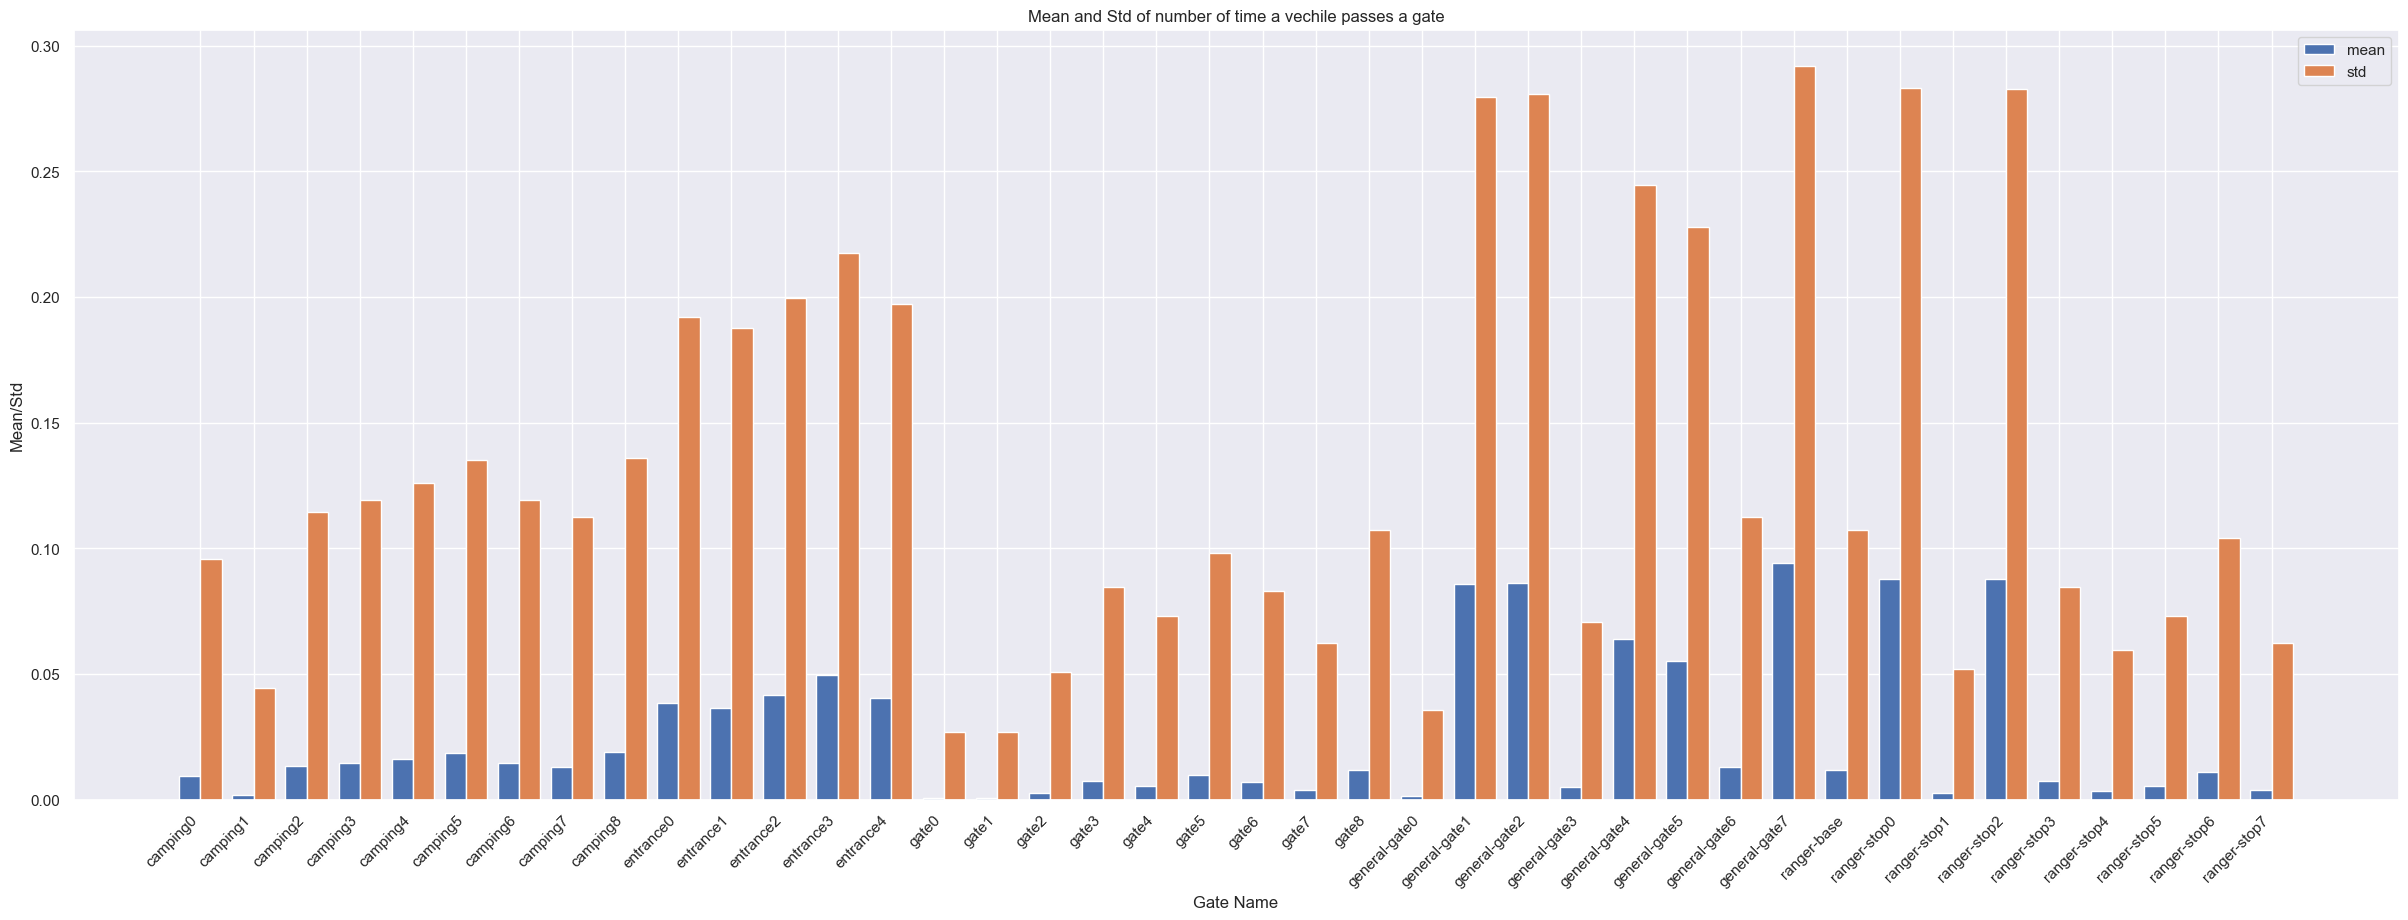

In [5]:
X = summary.columns
mean = list(summary.loc['mean'])
std = list(summary.loc['std'])
  
X_axis = np.arange(len(X)) 
fig = plt.figure(figsize=(30,10))
plt.bar(X_axis - 0.2, mean, 0.4, label = 'mean') 
plt.bar(X_axis + 0.2, std, 0.4, label = 'std') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Gate Name") 
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean/Std") 
plt.title("Mean and Std of number of time a vechile passes a gate") 
plt.legend() 
plt.show() 

# Traffic flux of different cars types aggregated over time period day and week.

In [6]:
df['count'] = np.ones(len(df))

In [7]:
colors = cm.rainbow(np.linspace(0, 1, 3))

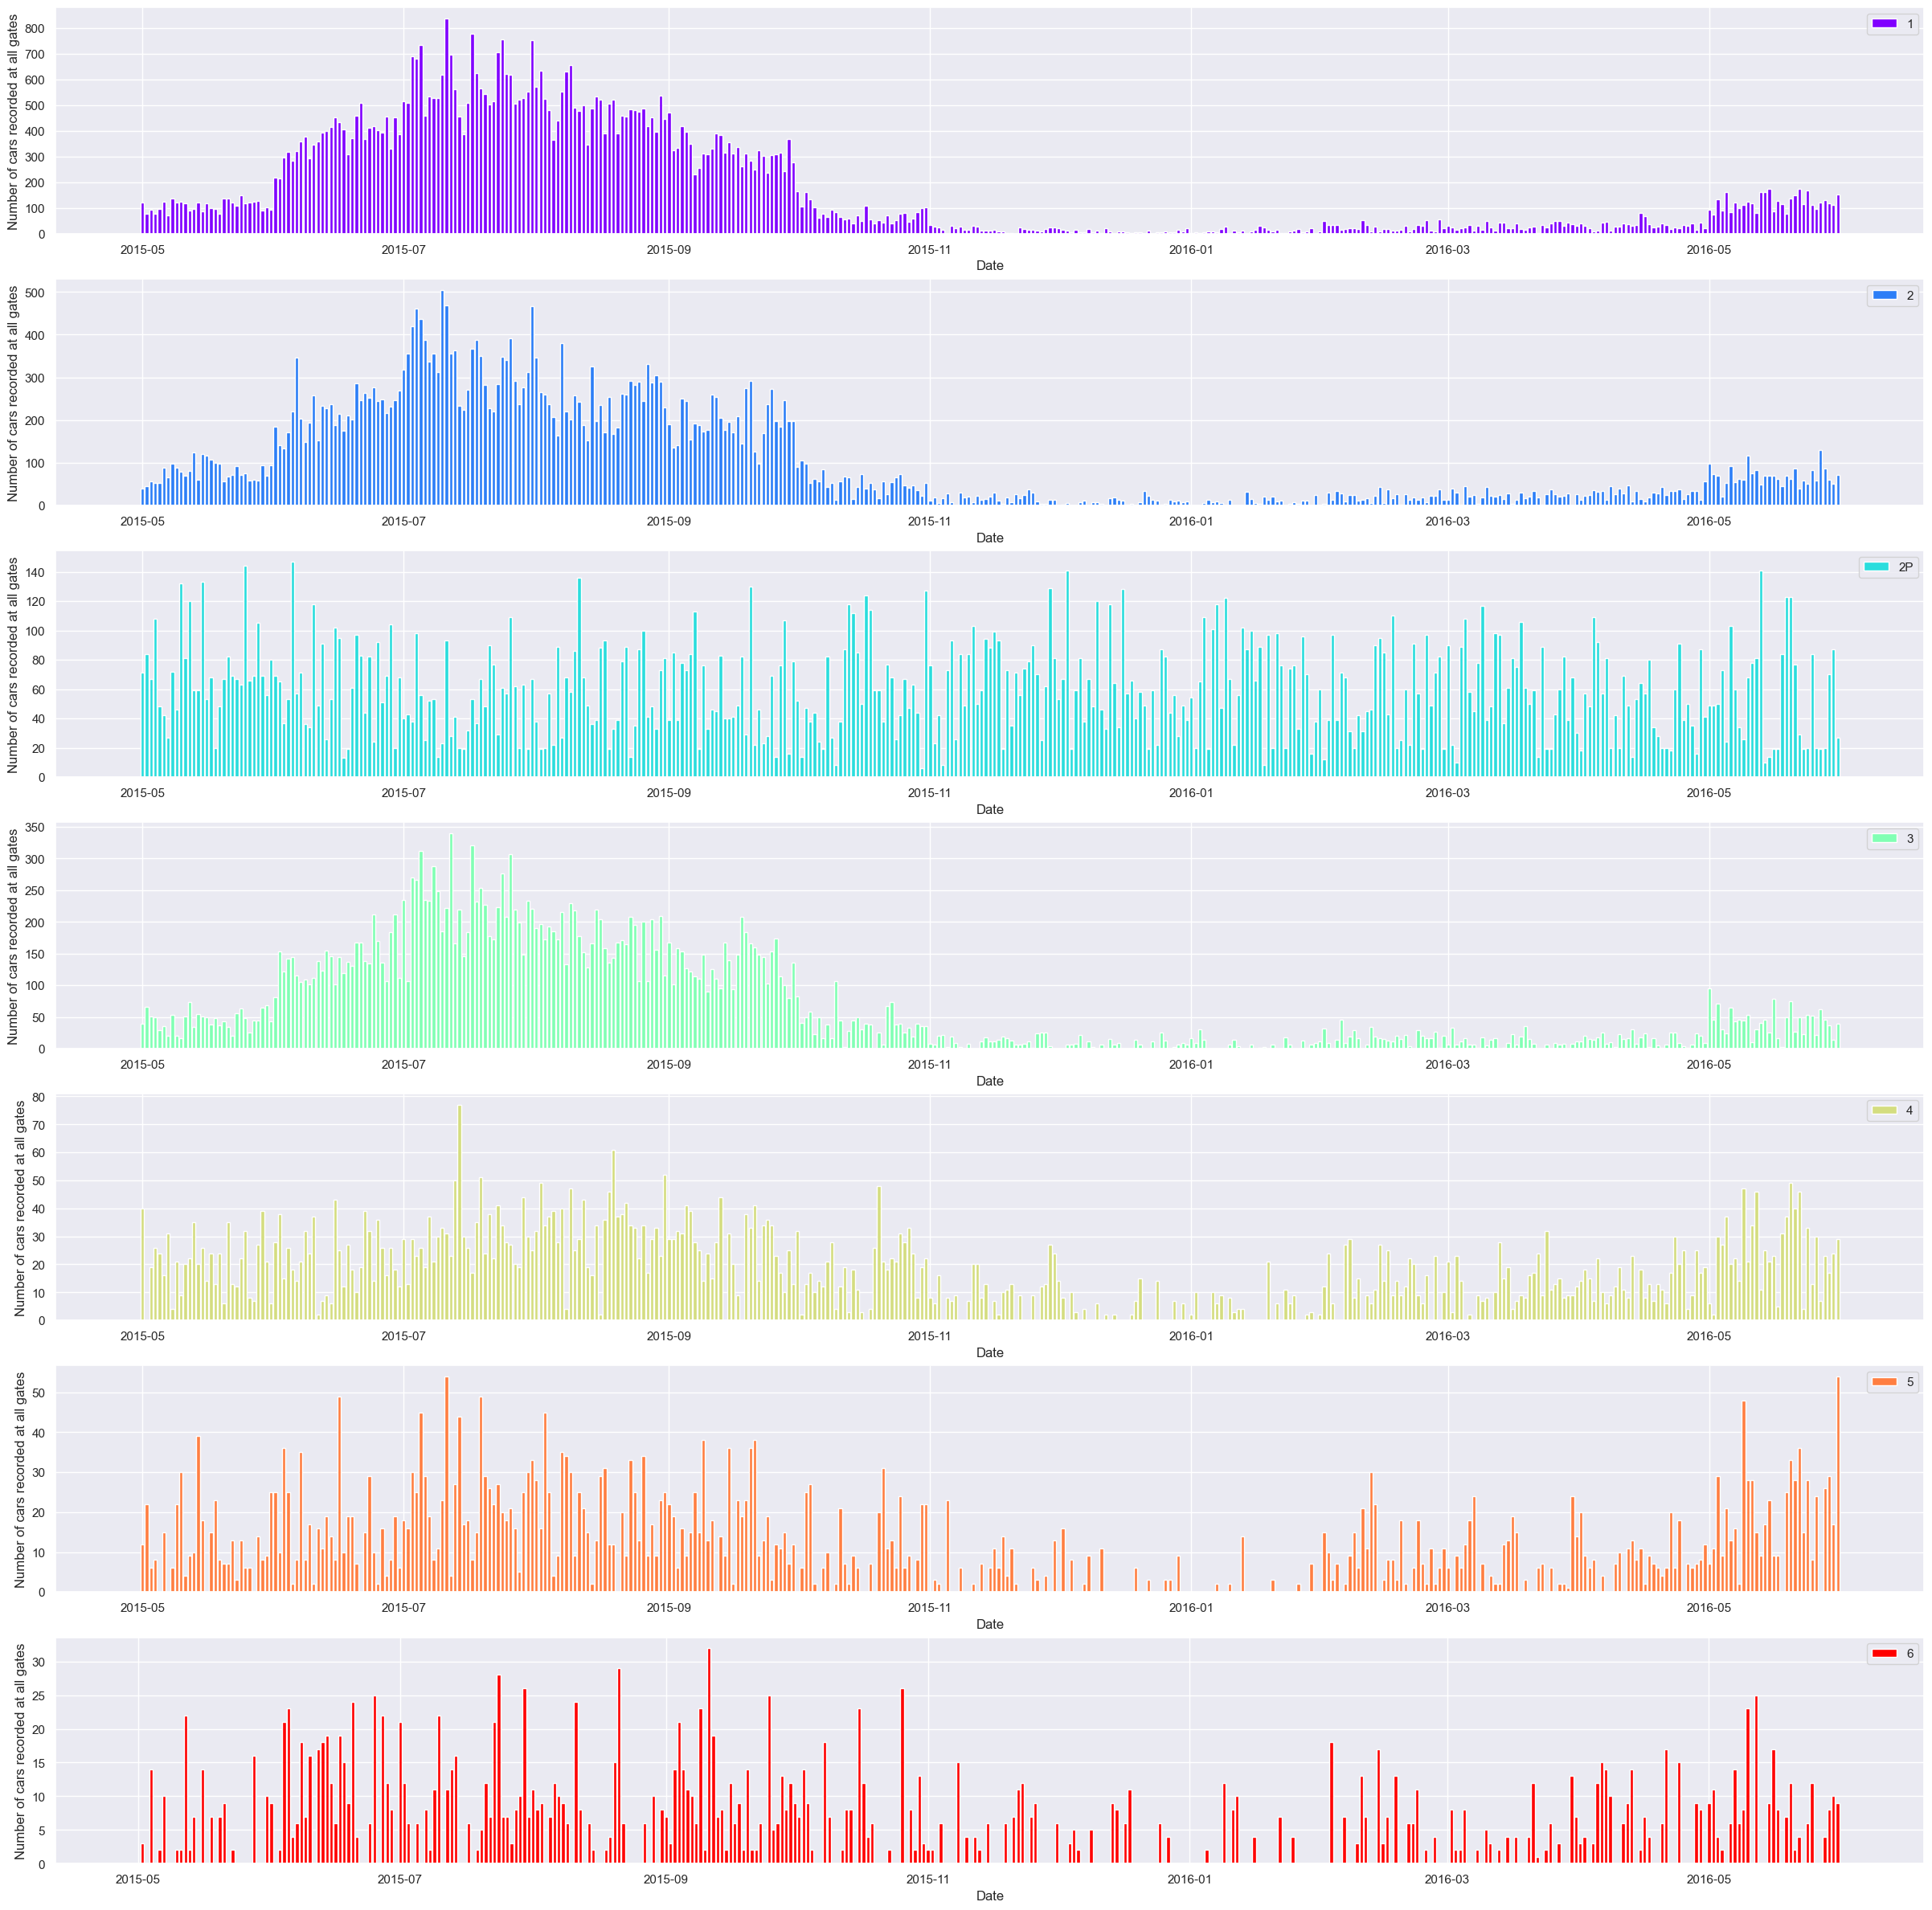

In [8]:
fig,ax = plt.subplots(7,1,figsize=(30,30))
cartypes = np.unique(df['car-type'])
colors = cm.rainbow(np.linspace(0, 1, len(cartypes)))
count = 0
ind = np.arange(len(cartypes))
width = 0.1
for cartype in cartypes:
    by_date = df[df['car-type']==cartype].groupby([df[df['car-type']==cartype].index.date])[['count']].sum()
    ax[count].bar(by_date.index, by_date['count'],label=cartype,color=colors[count])
    ax[count].legend()
    ax[count].set_xlabel("Date")
    ax[count].set_ylabel("Number of cars recorded at all gates")
    count+=1 
plt.show() 
    

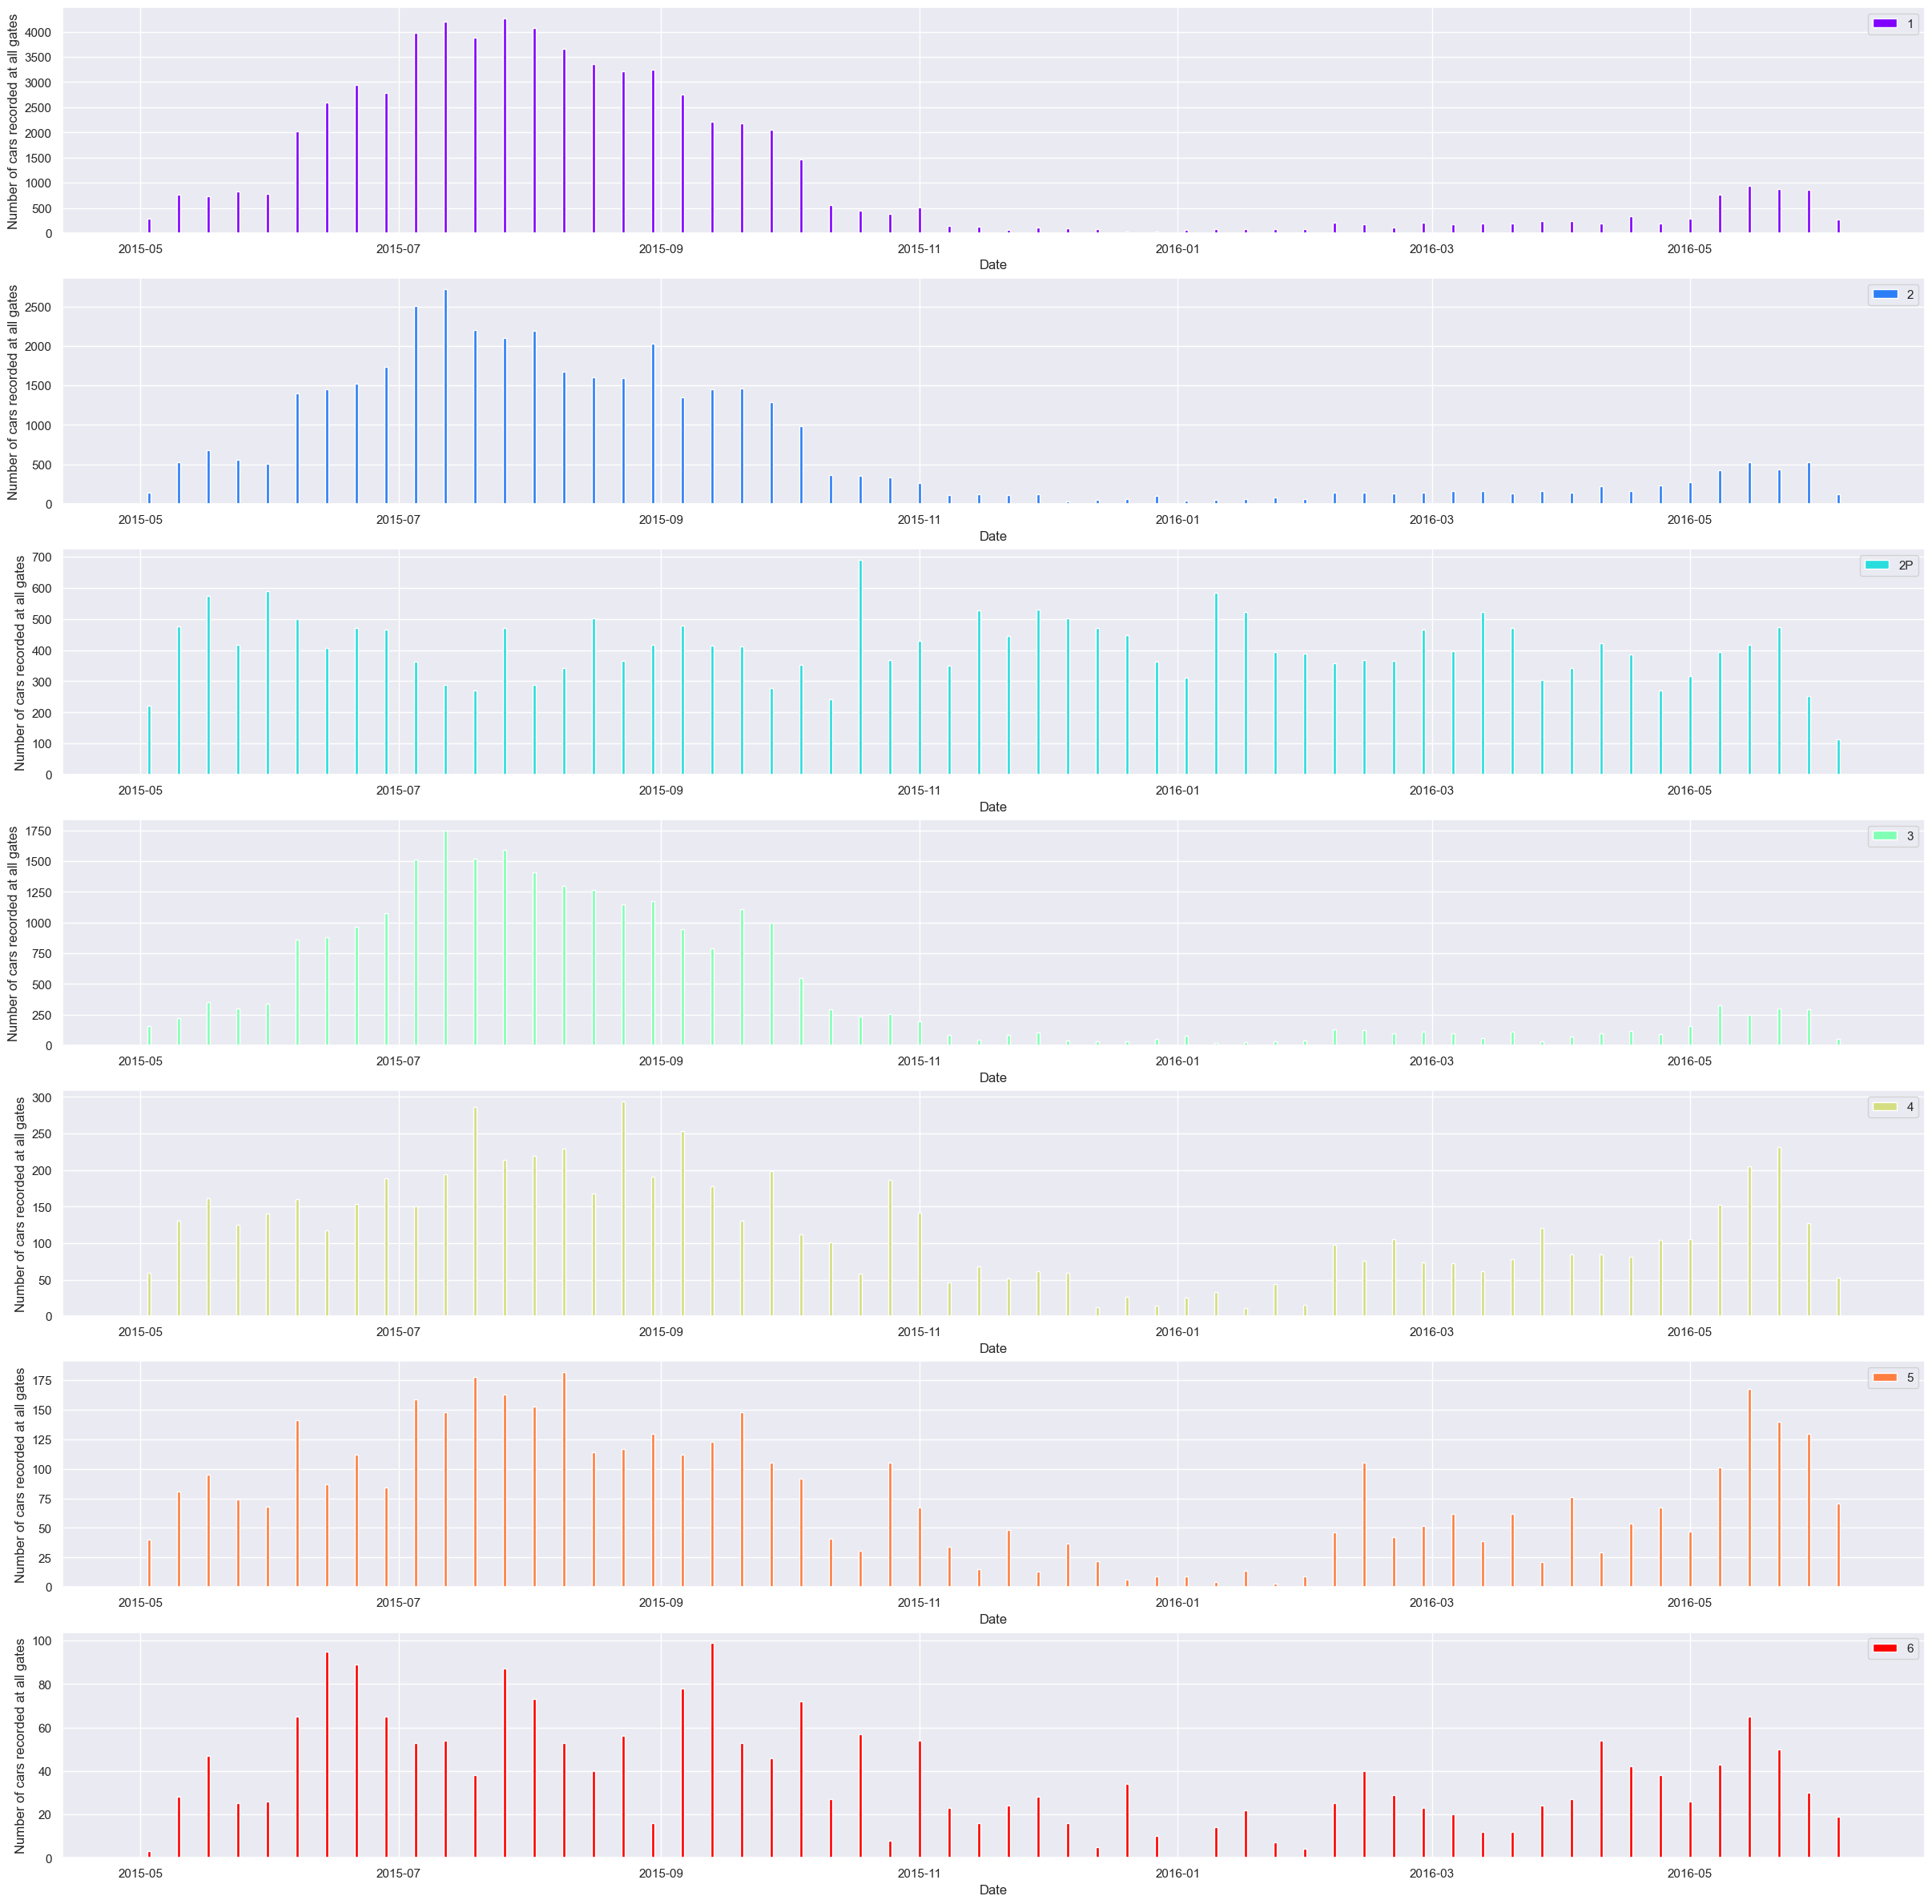

In [ ]:
fig,ax = plt.subplots(7,1,figsize=(30,30))
cartypes = np.unique(df['car-type'])
colors = cm.rainbow(np.linspace(0, 1, len(cartypes)))
count = 0
ind = np.arange(len(cartypes))
width = 0.1
for cartype in cartypes:
    by_week = df[df['car-type']==cartype].groupby(pd.Grouper(freq='W'))[['count']].sum()
    ax[count].bar(by_week.index, by_week['count'],label=cartype,color=colors[count])
    ax[count].legend()
    ax[count].set_xlabel("Date")
    ax[count].set_ylabel("Number of cars recorded at all gates")
    count+=1 
plt.show() 

# Traffic flux at each gate aggregated over time period day and week

In [ ]:
by_date_numerical_data = numerical_data.groupby(numerical_data.index.date)[numerical_data.columns[5:]].sum()

In [ ]:
by_date_numerical_data.head(2)

,camping1,camping2,camping3,camping4,camping5,camping6,camping7,camping8,entrance0,entrance1,...,general-gate7,ranger-base,ranger-stop0,ranger-stop1,ranger-stop2,ranger-stop3,ranger-stop4,ranger-stop5,ranger-stop6,ranger-stop7
2015-05-01,0,4,8,0,2,4,2,4,6,10,...,26,8,30,0,28,2,2,4,6,0
2015-05-02,0,3,5,2,3,3,1,3,11,11,...,27,6,23,2,23,4,2,2,8,6


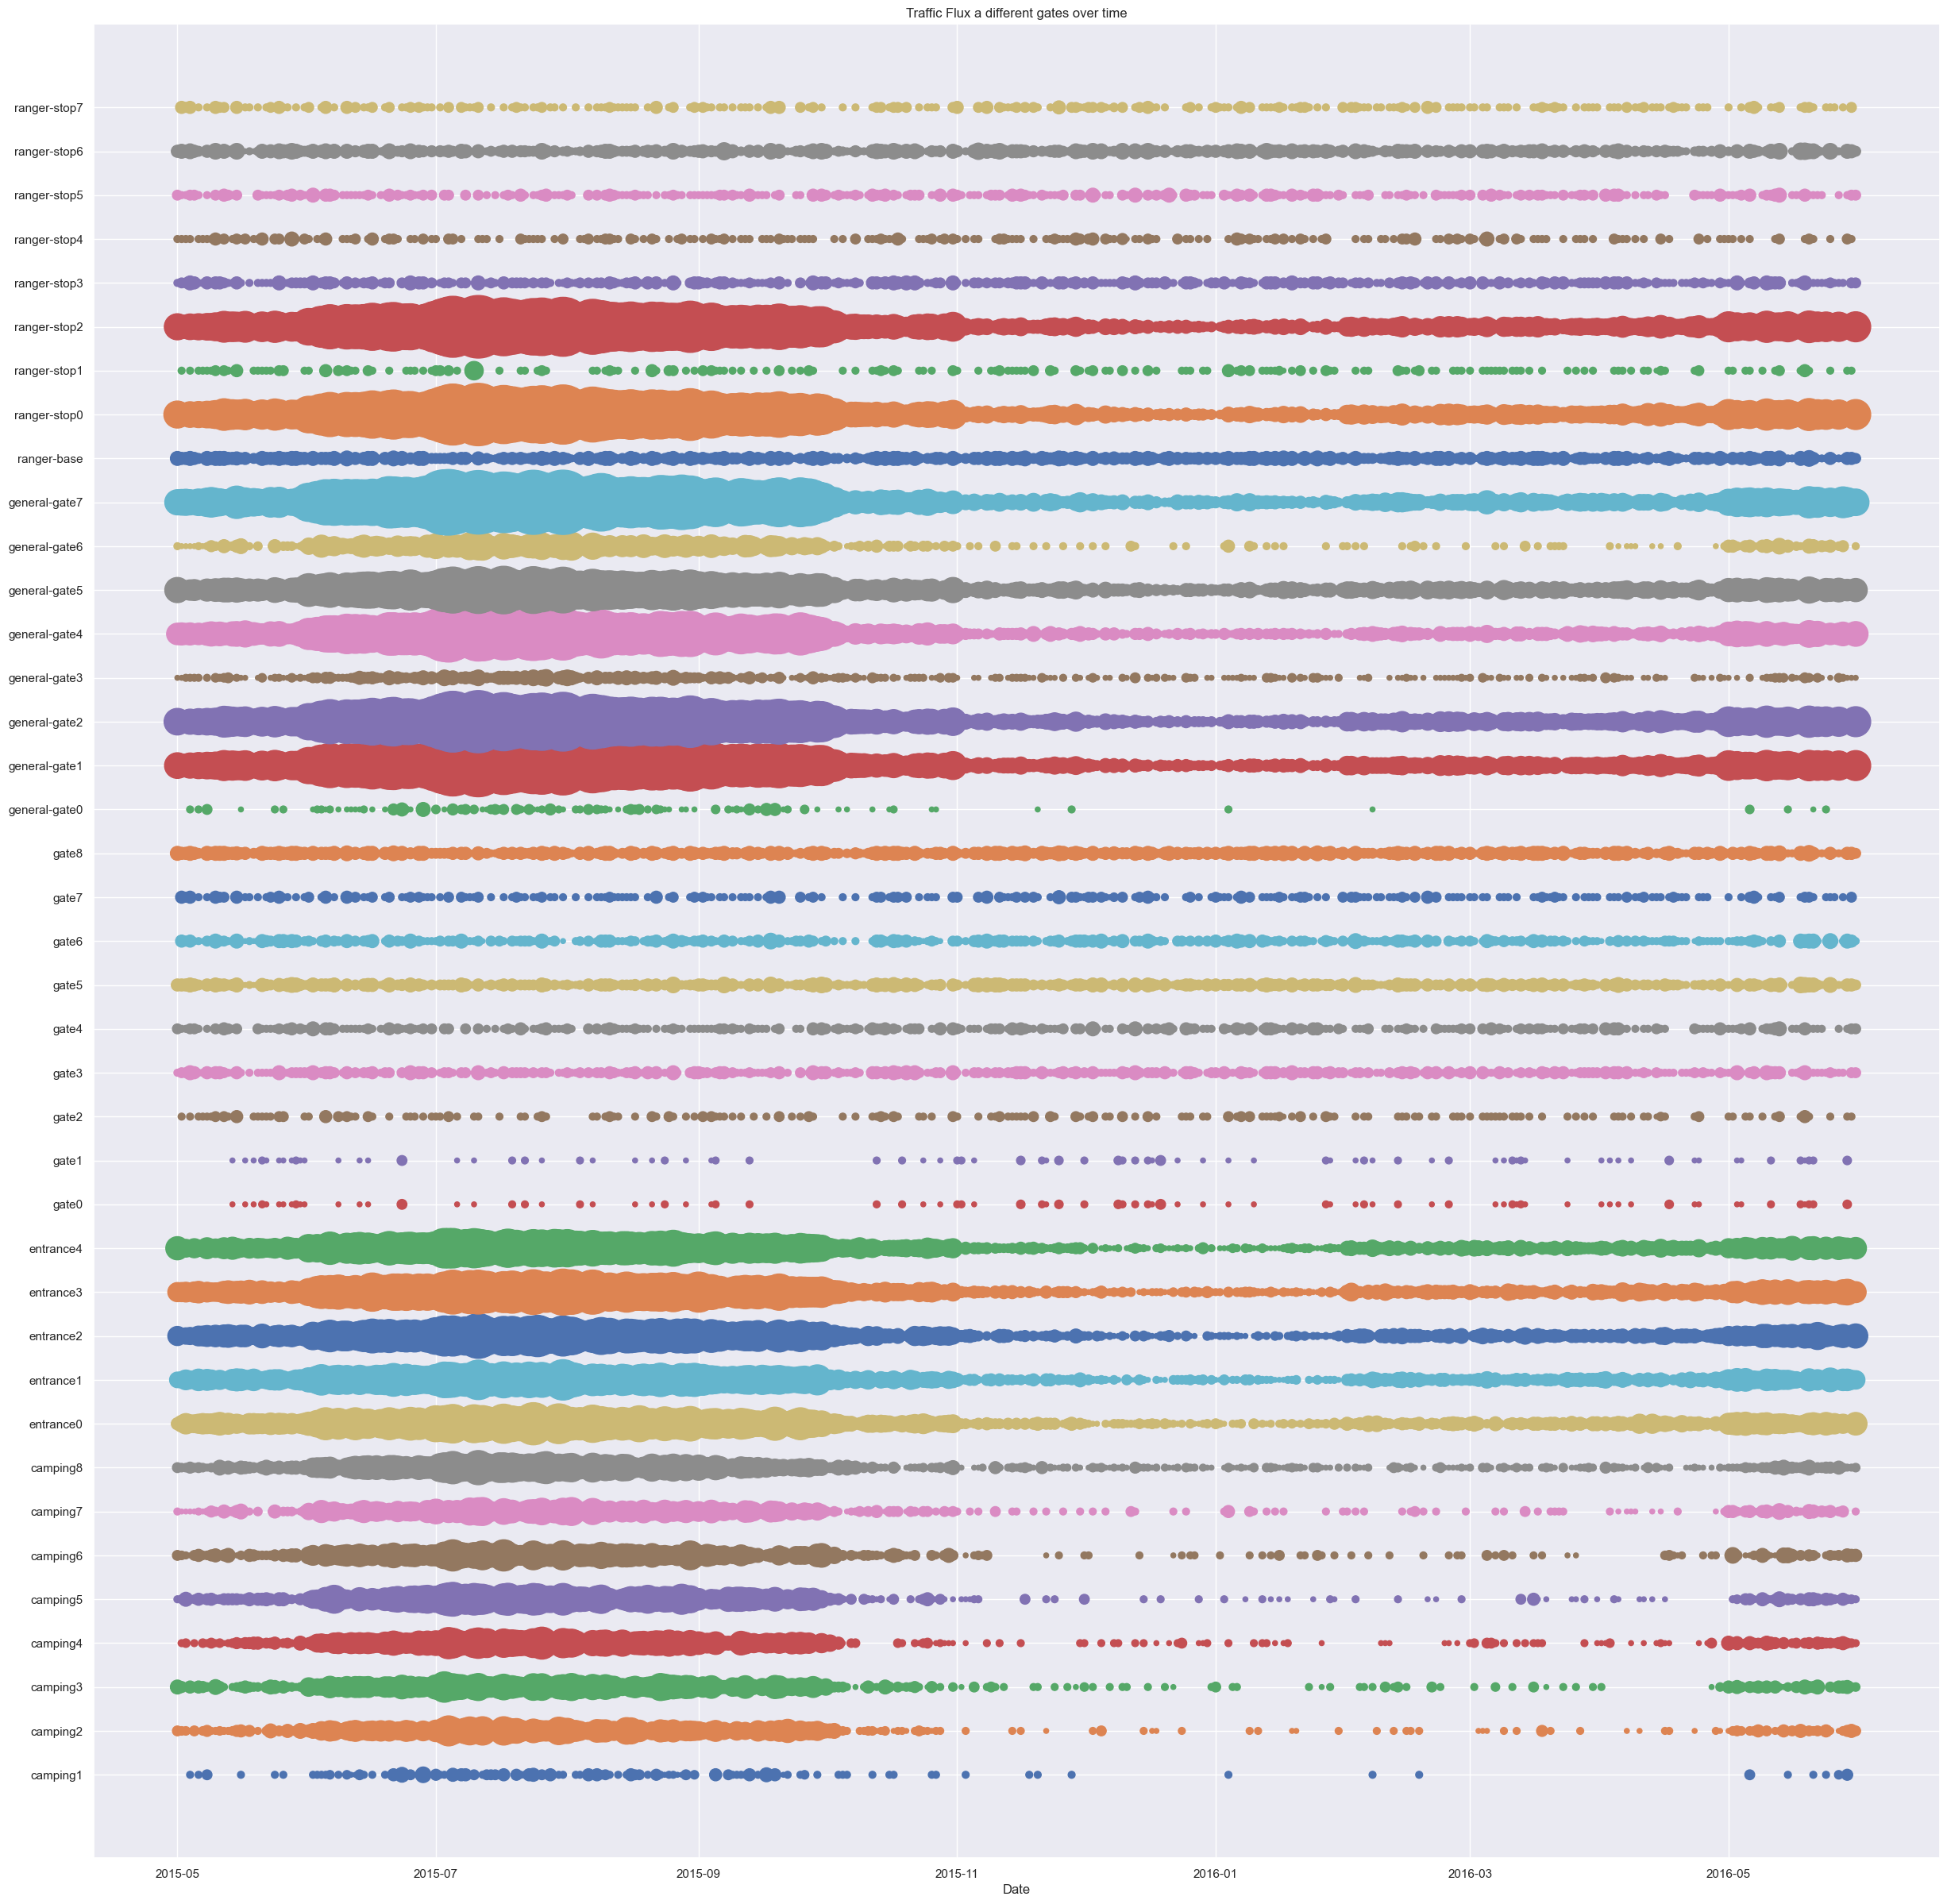

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
for col in by_date_numerical_data.columns:
    ax.scatter(by_date_numerical_data.index, [col] * len(by_date_numerical_data), s=by_date_numerical_data[col]*20, label=col)
ax.set_xlabel('Date')
ax.set_title('Traffic Flux a different gates over time')
plt.show()

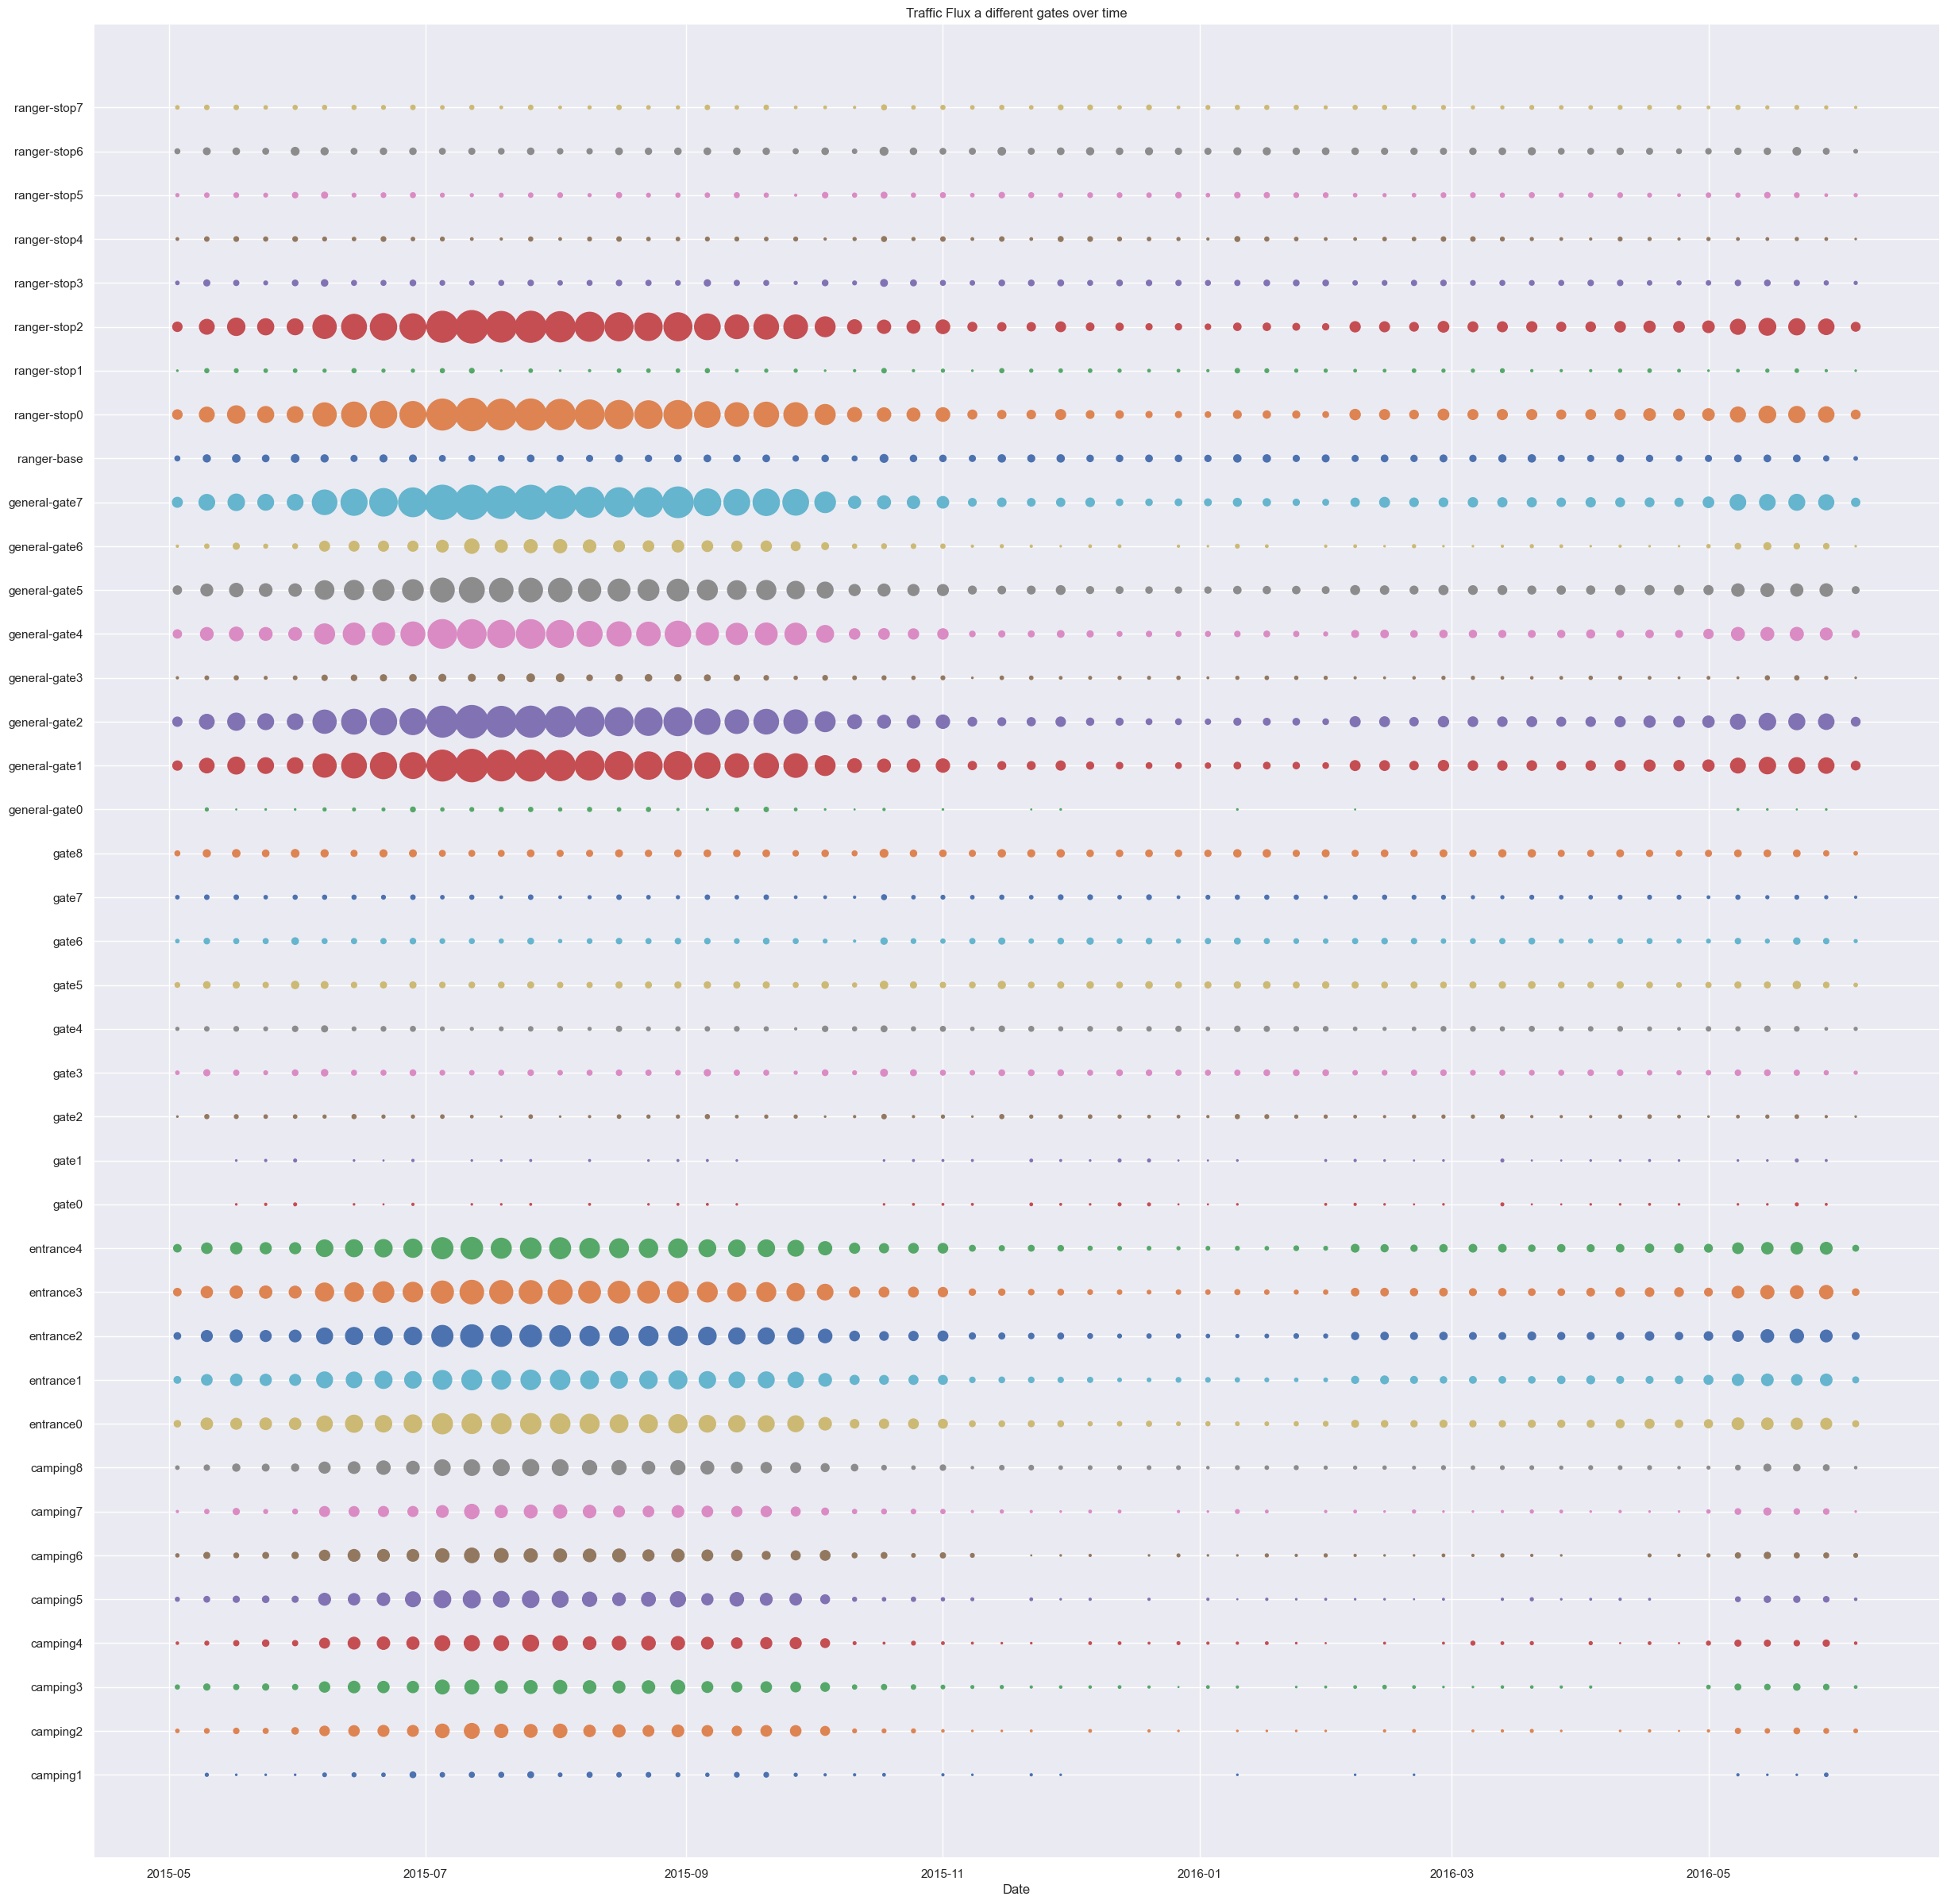

In [ ]:
by_week_numerical_data = numerical_data.groupby(pd.Grouper(freq='w'))[numerical_data.columns[5:]].sum()
fig, ax = plt.subplots(figsize=(30,30))
for col in by_week_numerical_data.columns:
    ax.scatter(by_week_numerical_data.index, [col] * len(by_week_numerical_data), s=by_week_numerical_data[col], label=col)
ax.set_xlabel('Date')
ax.set_title('Traffic Flux a different gates over time')
plt.show()

Need to fix bubble size
```
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

fig = make_subplots(rows=len(by_date_numerical_data.columns), cols=1,vertical_spacing=0)

i = 0
for  col in by_date_numerical_data.columns:
    fig.add_trace(px.scatter(x=by_date_numerical_data.index,y=[col]*len(by_date_numerical_data),size=by_date_numerical_data[col].values).data[0],row=i+1,col=1)
    i+=1

fig.update_layout(height=len(by_date_numerical_data.columns)*50)
fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_xaxes(showticklabels=True, row=40, col=1)
fig.update_layout(title=dict(text="Traffic flux at different gates over time", font=dict(size=20), automargin=True, yref='paper'))
fig.show()
```

# Change Data structure to JSON

In [138]:
def create_json(df):
    r"""retruns dictionary with keys data, edges and nodes 
        args:
        df (pd.DataFrame) : Lekagul Sensor Data 
    """
    pbar = tqdm(total=len(df))
    pbar.set_description("Data Processing :")

    car_ids = np.unique(df['car-id'])
    data_dic = {"data":[],"edges":None}
    data_dic["nodes"] = list(np.unique(df['gate-name']))
    all_edge_names = []
    for car_id in car_ids:
        row_data = {'car-id':car_id,'path_taken':[]}
        car_data = df[df['car-id']==car_id]
        row_data["car_type"] = np.unique(car_data['car-type'])[0]
        row_data['enter_date'] = str(car_data.index[0])
        row_data['exit_date'] = str(car_data.index[-1])
        total_time = car_data.index[-1]-car_data.index[0]
        total_time = total_time.total_seconds()/60
        row_data['total_in_time'] = round(total_time,2)
        for ind in range(1,len(car_data)):
            dic_key =car_data['gate-name'].iloc[ind-1]+ " to " +car_data['gate-name'].iloc[ind]
            delta = car_data.index[ind]-car_data.index[ind-1]
            delta = delta.total_seconds()/60
            
            row_data['path_taken'].append({dic_key:round(delta,2)})
            if dic_key not in all_edge_names:
                all_edge_names.append(dic_key)
        data_dic["data"].append(row_data)
        pbar.update(len(car_data))
    data_dic['edges'] =  all_edge_names
    pbar.close()
    return data_dic

In [139]:
def seperate_cartype_data(data):
    r"""returns data separated by cartype
        Args:
            Data (dictionary) : dic returned by create_json function"""
    new_dic = {'1':[], '2':[], '2P':[], '3':[], '4':[], '5':[], '6':[]}
    for one_car in data['data']:
        new_dic[one_car['car_type']].append(one_car)
        data['data'] = new_dic
    return data

In [ ]:
data_json = create_json(df)

In [ ]:
data = seperate_cartype_data(data_json)

In [ ]:
with open(os.path.join("/data/json_data.json", "w")) as outfile: 
    json.dump(data, outfile)

# Netwrok Graph

In [4]:
file_ = open(os.path.join(path,"data/json_data.json"))

In [5]:
data_json = json.loads(file_.read())

In [6]:
def get_edges(data):
    r"""returns normal and selfloop edges of a specific cartype
        args:
            data (dictionary) : dictionary data of a specific cartype"""
    edges = {"normal":{},"selfloop":{}}
    for car in data:
        for path in car['path_taken']:
            for key in path.keys():
                if (key.split(" ")[0]!=key.split(" ")[2]):
                    if key in edges['normal'].keys():
                        edges['normal'][key]['time'] += path[key]
                        edges['normal'][key]['count'] +=1
                    else:
                        edges['normal'][key] = { "time" : path[key],"count":1}
                else:
                    if key in edges['selfloop'].keys():
                        edges['selfloop'][key]['time'] += path[key]
                        edges['selfloop'][key]['count'] += 1
                        
                    else:
                        edges['selfloop'][key] = { "time" : path[key],"count":1}
                    
    return edges

archived
```
def get_node_visited_data(df):
    pbar = tqdm(total=len(df))
    pbar.set_description("Data Processing :")
    car_ids = np.unique(df['car-id'])
    columns = [["entry_time","exit_time","total_time","car_type","car_id"] + data_json['nodes']]
    for car_id in car_ids:
        row_data = [0]*len(columns[0])
        car_data = df[df['car-id']==car_id]
        row_data[4] = car_id
        row_data[3] = np.unique(car_data['car-type'])[0]
        row_data[0] = str(car_data.index[0])
        row_data[1] = str(car_data.index[-1])
        total_time = car_data.index[-1]-car_data.index[0]
        total_time = total_time.total_seconds()/60
        row_data[2] = round(total_time,2)
        for ind in range(len(car_data)):
            key =car_data['gate-name'].iloc[ind-1]
            row_data[columns[0].index(key)] = 1
        columns.append(row_data)   
        pbar.update(len(car_data))
    pbar.close()
    return columns
```

## Network of Car Type 1

In [7]:
all_edges = get_edges(data_json['data']['1']) 

In [8]:
n_edge_names = [(key.split(" ")[0],key.split(" ")[2]) for key in all_edges['normal'].keys()]
sl_edge_names = [(key.split(" ")[0],key.split(" ")[2]) for key in all_edges['selfloop'].keys()]

In [43]:
normal_nodes = []
for i in n_edge_names:
    if i[0] not in normal_nodes:
        normal_nodes.append(i[0])
    if i[1] not in normal_nodes:
        normal_nodes.append(i[1])
        

In [44]:
self_nodes = [i[0] for i in sl_edge_names]

In [10]:
n_car_on_edges =  preprocessing.normalize(np.array([i["count"] for i in all_edges['normal'].values()]).reshape(1,len(list(all_edges['normal'].values()))))
average_travel_time =  preprocessing.normalize(np.array([i['time']/i["count"] for i in all_edges['normal'].values()]).reshape(1,len(list(all_edges['normal'].values()))))

In [11]:

n_cars_stoped_at_node = preprocessing.normalize(np.array([i["count"] for i in all_edges['selfloop'].values()]).reshape(1,len(list(all_edges['selfloop'].values()))))
average_time_spent_at_node = preprocessing.normalize(np.array([i['time']/i["count"] for i in all_edges['selfloop'].values()]).reshape(1,len(list(all_edges['selfloop'].values()))))


In [17]:
graph_cartype_1 = nx.DiGraph()

In [18]:
graph_cartype_1.add_edges_from(n_edge_names)
#graph_cartype_1.add_edges_from(sl_edge_names)

### Extract Map Coordinates 

In [14]:
corordinates = pd.read_csv(os.path.join(path,"data/Mapping Park Area.csv"))

In [15]:
def adjust_map_coordinates(corordinates):
    y_cordinate = []
    midpoint = 982/2
    x_length = 982
    y_length = 982
    for j in list(corordinates['y_coordinate']):
        if j > midpoint:
            y_cordinate.append(y_length-j)
        elif j <midpoint:
            y_cordinate.append(x_length-j)
        else:
            y_cordinate.append(j)
    corordinates['y_coordinate'] = y_cordinate
    pos = {}
    for key,x,y in zip(list(corordinates['gate_name']),list(corordinates['x_coordinate']),list(corordinates['y_coordinate'])):
        pos[key] = np.array([x,y])
    return corordinates, pos

In [16]:
corordinates,pos = adjust_map_coordinates(corordinates)

### Network showing routes and stops

* Edge width shows number of cars passing
* Blue nodes are stop were car just passed 
* Green nodes are nodes were car have two consecutive readings 
* Intensity of green color represents average time between two consecutive readings.


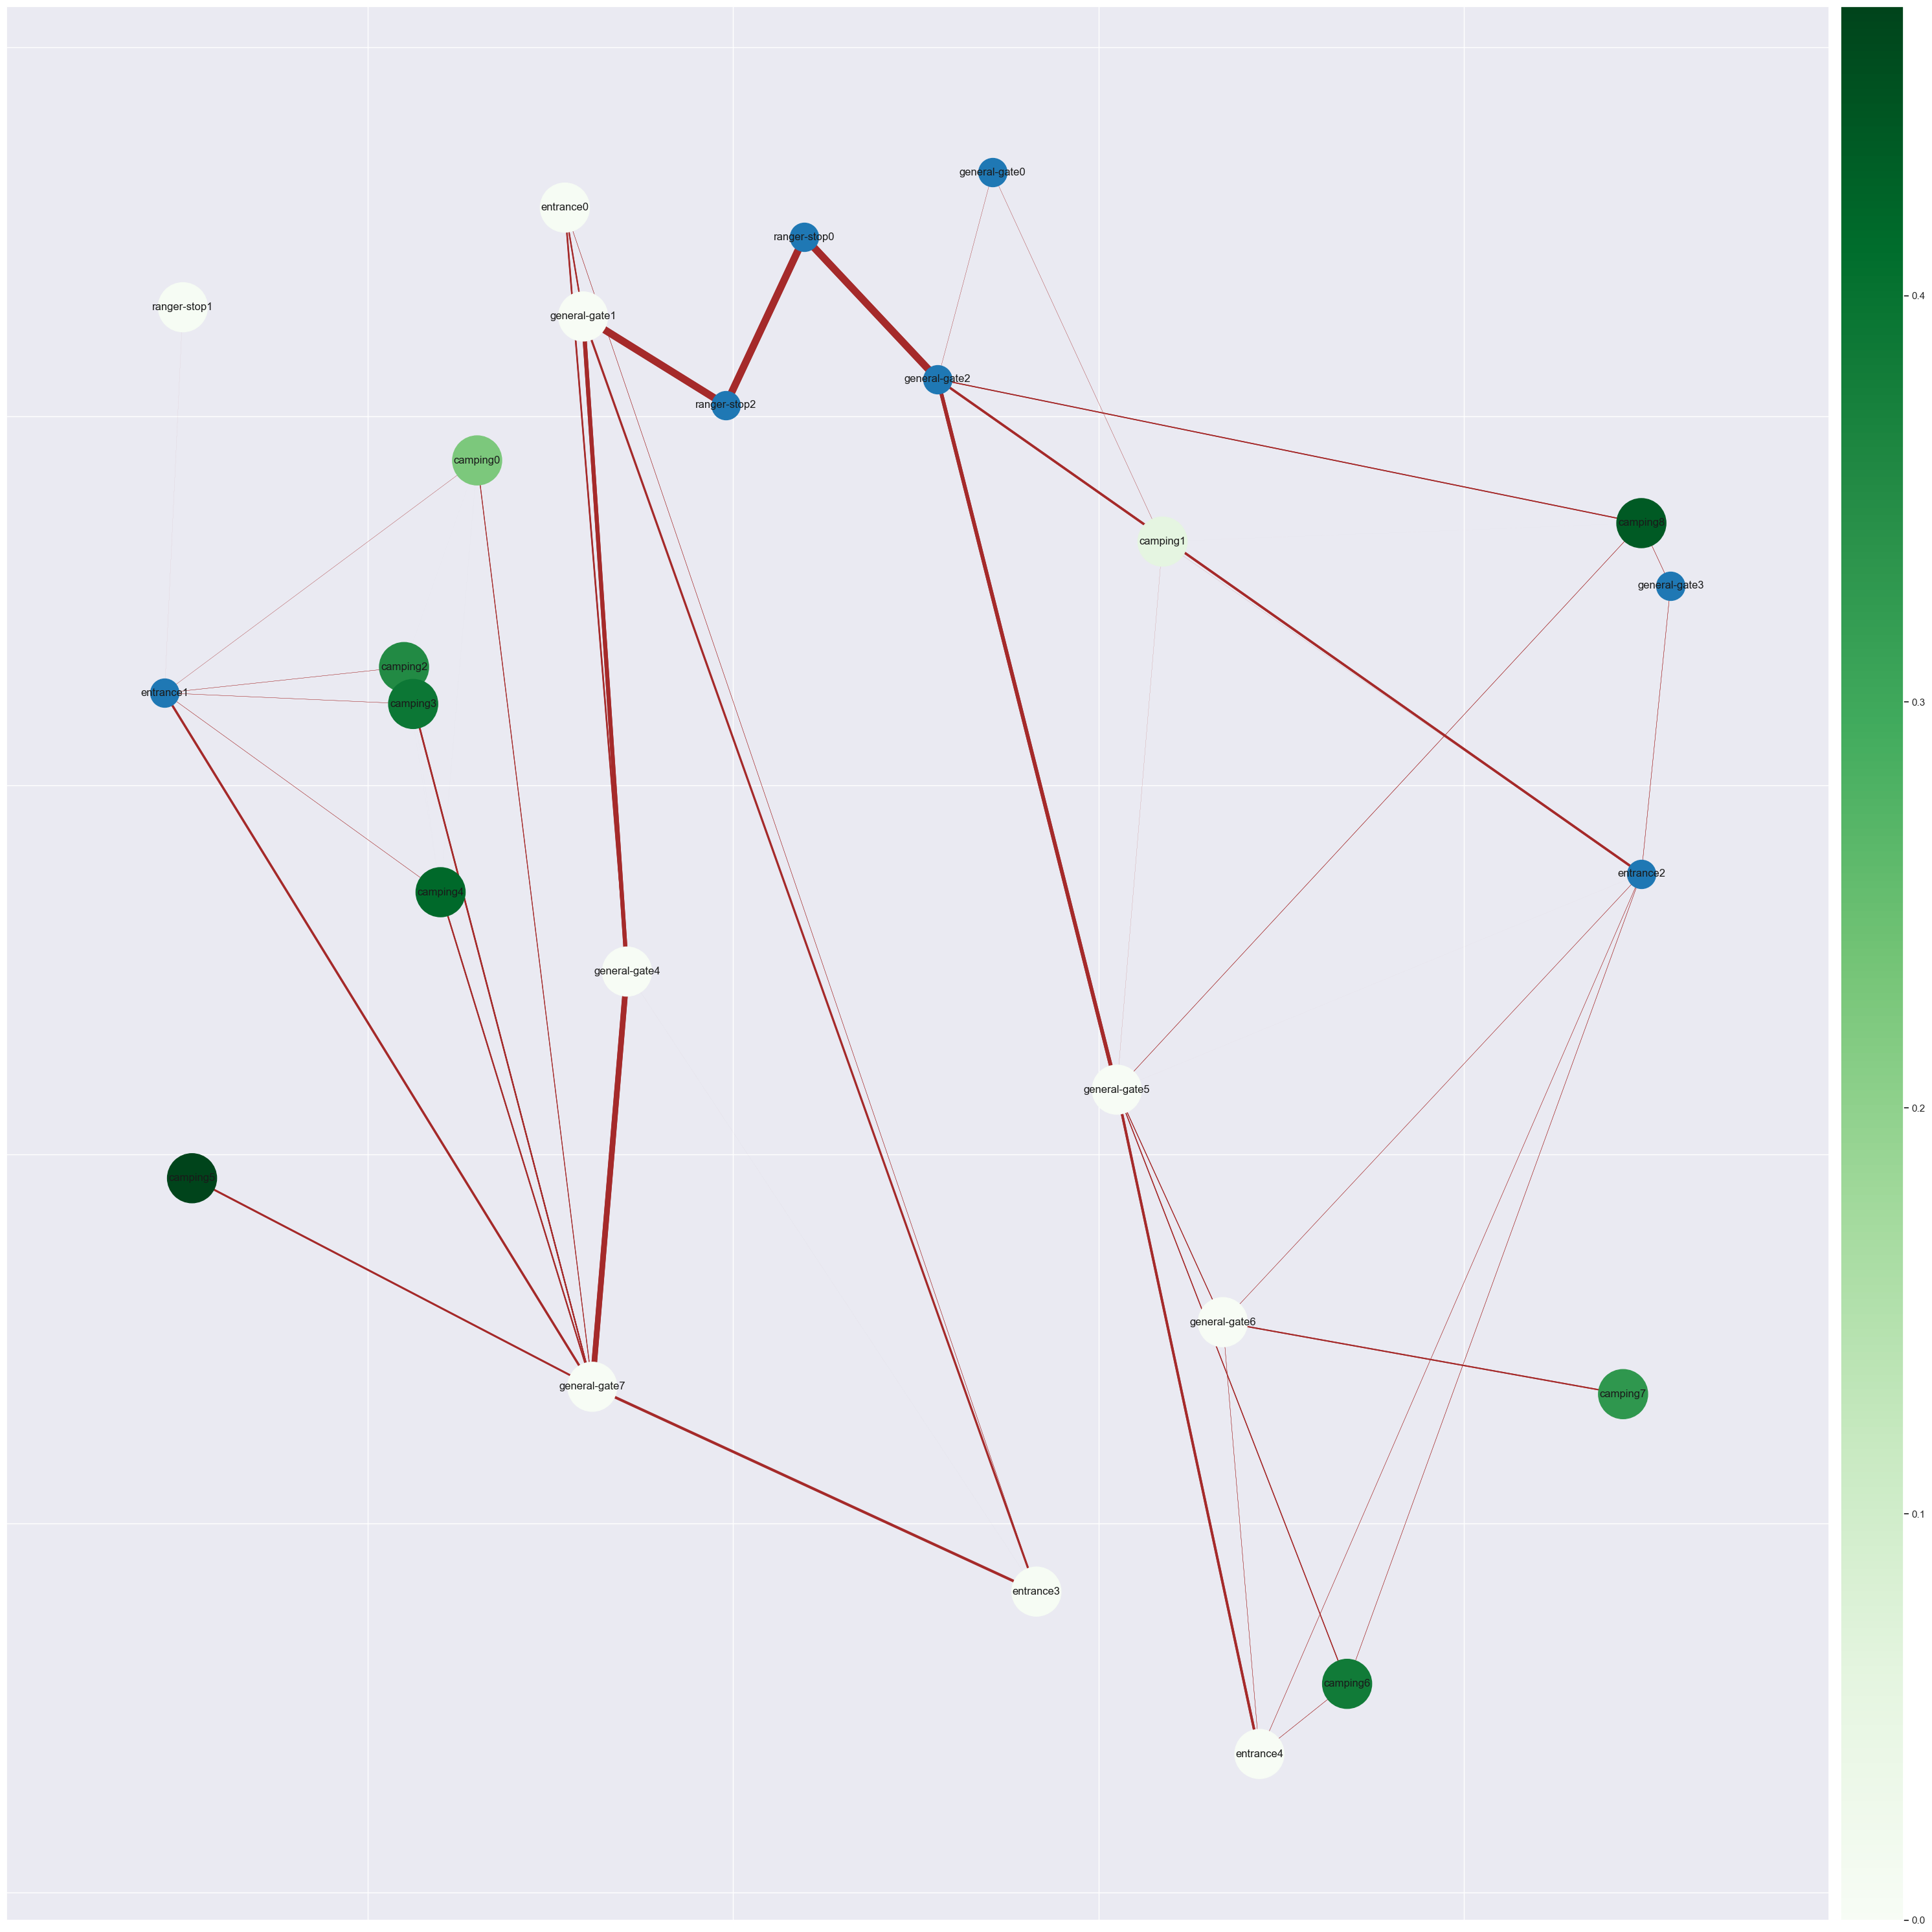

In [136]:

fig, ax = plt.subplots(1,2, figsize=(30,30), tight_layout=True,gridspec_kw={'width_ratios': [29, 1]}) 
n_colors = n_car_on_edges[0]
sl_my_cmap = plt.cm.Greens


sl_options = {
    "color": average_time_spent_at_node[0],
    "size" : n_cars_stoped_at_node[0],
    "edge_cmap": sl_my_cmap
}


nx.draw_networkx_nodes(graph_cartype_1,pos,nodelist=normal_nodes,ax=ax[0],node_size=1000)
nx.draw_networkx_nodes(graph_cartype_1,pos,nodelist = self_nodes,node_size=3000,node_color = n_cars_stoped_at_node[0],cmap= sl_my_cmap,ax=ax[0])
nx.draw_networkx_labels(graph_cartype_1, pos,ax= ax[0])
nx.draw_networkx_edges(graph_cartype_1, pos, edgelist= n_edge_names, arrows=False,ax=ax[0],**n_options)

sl_sm = ScalarMappable(cmap=sl_my_cmap, norm=plt.Normalize(0,max(average_time_spent_at_node[0])))
sl_sm._A = []
plt.colorbar(sl_sm,ax[1])

plt.show()

# anolomy

In [117]:
not_2p_df = df[df['car-type']!='2P'][df.columns[:-1]]

In [119]:
illegal_pass = not_2p_df[not_2p_df['gate-name'].isin(['gate1','gate2','gate3','gate4','gate5','gate6','gate7','gate8'])]

In [120]:
illegal_pass

,car-id,car-type,gate-name
Timestamp,,,
2015-05-05 02:07:15,20150505020522-625,4,gate6
2015-05-05 02:09:18,20150505020522-625,4,gate5
2015-05-05 02:22:24,20150505020522-625,4,gate3
2015-05-05 02:40:51,20150505020522-625,4,gate3
2015-05-05 02:53:55,20150505020522-625,4,gate5
...,...,...,...
2016-05-31 02:49:37,20164531024545-131,4,gate5
2016-05-31 03:02:20,20164531024545-131,4,gate3
2016-05-31 03:20:18,20164531024545-131,4,gate3


In [121]:
dummy_ = pd.get_dummies(illegal_pass['gate-name'],dtype=int)

In [122]:
illegal_num_data = pd.concat((illegal_pass,dummy_),axis=1)

In [137]:
illegal_num_data.head(2)

,car-id,car-type,gate-name,gate3,gate5,gate6
Timestamp,,,,,,
2015-05-05 02:07:15,20150505020522-625,4,gate6,0,0,1
2015-05-05 02:09:18,20150505020522-625,4,gate5,0,1,0


In [124]:
by_date_illegal_pass = illegal_num_data.groupby(illegal_num_data.index.date)[illegal_num_data.columns[3:]].sum()

In [125]:
g3 = by_date_illegal_pass['gate3']!=0
g5 = by_date_illegal_pass['gate5']!=0
g6 = by_date_illegal_pass['gate6']!=0

In [126]:
len(g3), len(g5),len(g6)

(23, 23, 23)

In [127]:
ind_with_value = g3 | g5 | g6

In [128]:
by_date_illegal_pass[ind_with_value]

,gate3,gate5,gate6
2015-05-05,2,2,2
2015-05-21,2,2,2
2015-06-02,2,2,2
2015-06-16,2,2,2
2015-06-25,2,2,2
2015-07-07,2,2,2
2015-07-14,2,2,2
2015-07-23,2,2,2
2015-08-04,2,2,2
2015-08-20,2,2,2


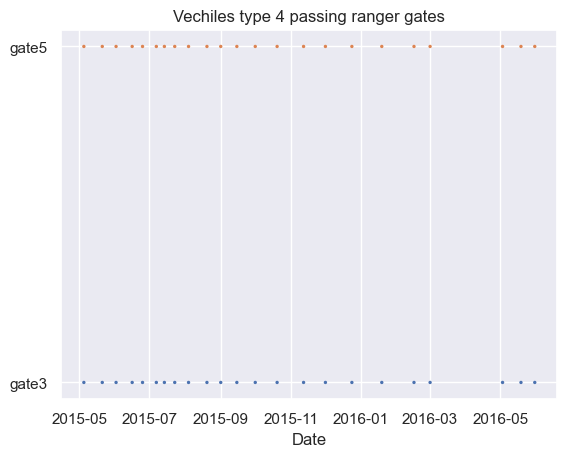

In [129]:
fig, ax = plt.subplots()
for col in by_date_illegal_pass.columns[:-1]:
    ax.scatter(by_date_illegal_pass.index, [col] * len(by_date_illegal_pass), s=by_date_illegal_pass[col], label=col)
ax.set_xlabel('Date')
ax.set_title('Vechiles type 4 passing ranger gates')
plt.show()

In [135]:
cars_with_illegal_pass = not_2p_df[not_2p_df['car-id'].isin(illegal_pass['car-id'])]
np.unique(cars_with_illegal_pass['car-id'])
routes = []
for i in np.unique(cars_with_illegal_pass['car-id']):
    new_route = "->".join(list(cars_with_illegal_pass[cars_with_illegal_pass['car-id']==i]['gate-name']))
    if new_route not in routes:
        print(new_route)
        routes.append(new_route)

entrance3->gate6->ranger-stop6->gate5->general-gate5->gate3->ranger-stop3->ranger-stop3->gate3->general-gate5->gate5->ranger-stop6->gate6->entrance3


In [142]:
illegal_pass_json = create_json(cars_with_illegal_pass)

Data Processing :: 100%|██████████| 322/322 [00:00<00:00, 9926.03it/s]


In [143]:
illegal_pass_json = seperate_cartype_data(illegal_pass_json)

In [148]:
illegal_pass_edges = get_edges(illegal_pass_json['data']['4'])

In [165]:
n_edge_names = [(key.split(" ")[0],key.split(" ")[2]) for key in illegal_pass_edges['normal'].keys()]
sl_edge_names = [(key.split(" ")[0],key.split(" ")[2]) for key in illegal_pass_edges['selfloop'].keys()]

In [166]:
normal_nodes = []
for i in n_edge_names:
    if i[0] not in normal_nodes:
        normal_nodes.append(i[0])
    if i[1] not in normal_nodes:
        normal_nodes.append(i[1])

In [167]:
self_nodes = [i[0] for i in sl_edge_names]

In [168]:
n_car_on_edges =  preprocessing.normalize(np.array([i["count"] for i in illegal_pass_edges['normal'].values()]).reshape(1,len(list(illegal_pass_edges['normal'].values()))))
average_travel_time =  preprocessing.normalize(np.array([i['time']/i["count"] for i in illegal_pass_edges['normal'].values()]).reshape(1,len(list(illegal_pass_edges['normal'].values()))))

In [169]:
n_cars_stoped_at_node = preprocessing.normalize(np.array([i["count"] for i in illegal_pass_edges['selfloop'].values()]).reshape(1,len(list(illegal_pass_edges['selfloop'].values()))))
average_time_spent_at_node = preprocessing.normalize(np.array([i['time']/i["count"] for i in illegal_pass_edges['selfloop'].values()]).reshape(1,len(list(illegal_pass_edges['selfloop'].values()))))

In [170]:
illagel_graph = nx.DiGraph()

In [171]:
illagel_graph.add_edges_from(n_edge_names)

In [174]:
def plot_graph(graph,edges,normal_nodes,self_nodes,edge_weights): 
    fig, ax = plt.subplots(1,2, figsize=(7,7), tight_layout=True,gridspec_kw={'width_ratios': [6, 1]}) 
    pos = nx.spring_layout(graph,seed=63)
    n_my_cmap = plt.cm.Oranges
    n_options = {
        "edge_color": edge_weights,
        "width" : 6,
        "edge_cmap": n_my_cmap
    }
    nx.draw_networkx_nodes(illagel_graph, pos,nodelist=normal_nodes,node_color="Blue",ax=ax[0])
    nx.draw_networkx_nodes(illagel_graph, pos,nodelist=self_nodes,node_color="Green",ax=ax[0])
    nx.draw_networkx_labels(illagel_graph, pos,ax= ax[0])
    nx.draw_networkx_edges(graph, pos, edgelist= edges, arrows=False,ax=ax[0],**n_options)
    n_sm = ScalarMappable(cmap=n_my_cmap, norm=plt.Normalize(0,max(edge_weights)))
    n_sm._A = []
    plt.colorbar(n_sm,ax[1])
    plt.show()

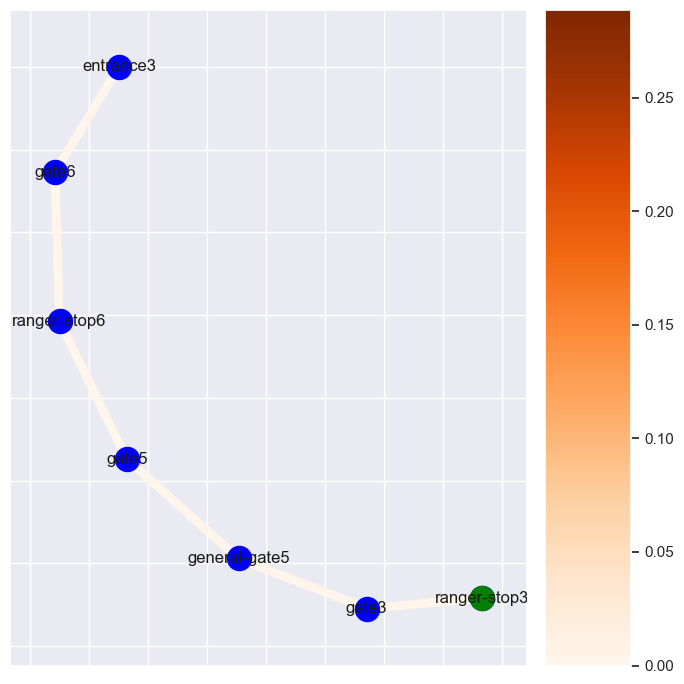

In [175]:
plot_graph(illagel_graph,n_edge_names,normal_nodes,self_nodes,n_car_on_edges[0])